<a href="https://colab.research.google.com/github/mehmetdamkaci/Monophonic_Pitch_Detection/blob/main/NSynth_pitchDetection_stft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
!wget http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-valid.jsonwav.tar.gz

--2023-04-16 20:30:17--  http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
Resolving download.magenta.tensorflow.org (download.magenta.tensorflow.org)... 142.250.141.128, 2607:f8b0:4023:c0b::80
Connecting to download.magenta.tensorflow.org (download.magenta.tensorflow.org)|142.250.141.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349501546 (333M) [application/gzip]
Saving to: ‘nsynth-test.jsonwav.tar.gz’

nsynth-test.jsonwav 100%[===================>] 333.31M  81.1MB/s    in 4.1s    

2023-04-16 20:30:21 (81.1 MB/s) - ‘nsynth-test.jsonwav.tar.gz’ saved [349501546/349501546]

--2023-04-16 20:30:21--  http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-valid.jsonwav.tar.gz
Resolving download.magenta.tensorflow.org (download.magenta.tensorflow.org)... 142.250.141.128, 2607:f8b0:4023:c0b::80
Connecting to download.magenta.tensorflow.org (download.magenta.tensorflow.org)|142.250.141.128|:80... connected.
HTTP request s

In [ ]:
!gunzip < nsynth-test.jsonwav.tar.gz | tar xvf -
!gunzip < nsynth-valid.jsonwav.tar.gz | tar xvf -

In [ ]:
!wget http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-train.jsonwav.tar.gz

--2023-05-08 07:38:33--  http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-train.jsonwav.tar.gz
Resolving download.magenta.tensorflow.org (download.magenta.tensorflow.org)... 108.177.12.128, 2607:f8b0:400c:c08::80
Connecting to download.magenta.tensorflow.org (download.magenta.tensorflow.org)|108.177.12.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23815298079 (22G) [application/gzip]
Saving to: ‘nsynth-train.jsonwav.tar.gz’

nsynth-train.jsonwa 100%[===================>]  22.18G   146MB/s    in 3m 21s  

2023-05-08 07:41:55 (113 MB/s) - ‘nsynth-train.jsonwav.tar.gz’ saved [23815298079/23815298079]



In [ ]:
!tar -xzvf nsynth-train.jsonwav.tar.gz && rm nsynth-train.jsonwav.tar.gz

In [ ]:
import pandas as pd 
import json
import librosa
from tqdm import tqdm
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
import random
from google.colab import drive

drive.mount('/content/gdrive')
pitchIDSelect=np.load('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/pitcID_71Class.npy')

numClass=len(pitchIDSelect)
numOfColumn=42
numOfRow=1025

# .json uzantılı dosyayı pandas dataframe'ine dönüştürür.
def jsonTOcsv(path):
  with open(path,'r') as f:
    data = json.loads(f.read())
  dataFrame=pd.DataFrame(data.values(),index=data.keys())

  return dataFrame

# .wav uzantılı dosyaları okur.
def readWav(frame, path):
  sortTimePath=list()
  timeList=list()
  megaDataList=list()

  for wavPath in tqdm(frame.index, desc='Data Reading'):
    wavData, sampleRate=librosa.load(path+wavPath+'.wav', sr=16000)
    megaDataList.append(wavData)
    time=len(wavData)/sampleRate
    timeList.append(time)
    if time<1.3152:
      sortTimePath.append(wavPath)
    
  print(f'\nMinumum Time : {min(timeList):.5f} \n')

  return megaDataList, sortTimePath

# one hot encoding işlemini yapar.
numClass=len(pitchIDSelect)
def oneHotEnc(number):
  label=np.zeros((numClass), dtype=np.uint8)
  label[number-min(pitchIDSelect)]=1
  return label

# .wav uzantılı dosyayı okur ve stft uygular
def setData(Data, Label, pathList, pitchIDList, filePath):
  pbar=tqdm(total=len(pathList))
  for index, (path, note) in enumerate(zip(pathList,pitchIDList)):
    data=librosa.load(filePath+path+'.wav', sr=16000)[0]
    stftWav=librosa.stft(data, n_fft=2048)
    Data[index]=np.log10(np.abs(stftWav[:,:numOfColumn])+1e-16)
    Label[index]=oneHotEnc(note)  
    pbar.update(1)
  pbar.close()
  return Data, Label

# verilerin son 6 sütununun sıfır olup olmadığını kontrol eder.
def dataControl(dataset):
  delList=list()
  for i in tqdm(range(len(dataset)), desc='Data Checking'):
    a=0
    for j in range(numOfRow):
      for k in range(6):
        if dataset[i][:,numOfColumn-6:][j][k]==-16.0 :
          pass
        else:
          a+=1
    if a==0:
      delList.append(i)
  return delList

# Verileri görselleştirir.
def drawSpec(data, label):
  plt.figure(figsize=(25,10))
  for i in range(8):
    index=random.randint(0,len(data))
    plt.subplot(2, 4, i+1)
    librosa.display.specshow(data[index].reshape(numOfRow,numOfColumn), sr=16000, 
                             hop_length=2048//4, x_axis='s', y_axis='hz', cmap='viridis')
    plt.title(np.where(label[index]==1)[0][0])
  plt.show()

Mounted at /content/gdrive


#Train Datası ile Test

In [ ]:
trainFrame=jsonTOcsv('/content/nsynth-train/examples.json')
trainFrame=trainFrame.loc[trainFrame['pitch'].isin(pitchIDSelect)]
trainFrame

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities
guitar_acoustic_001-082-050,16629,16000,82,0,guitar,guitar_acoustic_001,guitar_acoustic_001-082-050,[percussive],acoustic,50,3,39,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
organ_electronic_120-050-127,88495,16000,50,1,organ,organ_electronic_120,organ_electronic_120-050-127,[],electronic,127,6,979,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
organ_electronic_011-079-075,244275,16000,79,1,organ,organ_electronic_011,organ_electronic_011-079-075,[bright],electronic,75,6,188,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
keyboard_electronic_089-044-100,282051,16000,44,1,keyboard,keyboard_electronic_089,keyboard_electronic_089-044-100,[],electronic,100,4,877,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
bass_synthetic_016-080-127,277634,16000,80,2,bass,bass_synthetic_016,bass_synthetic_016-080-127,"[bright, long_release]",synthetic,127,0,241,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
organ_electronic_083-039-100,190815,16000,39,1,organ,organ_electronic_083,organ_electronic_083-039-100,[dark],electronic,100,6,808,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
bass_electronic_024-053-025,81228,16000,53,1,bass,bass_electronic_024,bass_electronic_024-053-025,[distortion],electronic,25,0,847,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
string_acoustic_082-058-100,20732,16000,58,0,string,string_acoustic_082,string_acoustic_082-058-100,[reverb],acoustic,100,8,699,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
reed_acoustic_020-056-100,28856,16000,56,0,reed,reed_acoustic_020,reed_acoustic_020-056-100,[],acoustic,100,7,200,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
import tensorflow as tf

class CustomAttentionLayer(tf.keras.layers.Layer):
    def __init__(self,  activation=None):
        super(CustomAttentionLayer, self).__init__()
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):

        self.input_dim = input_shape[-1]
        self.w = self.add_weight(
            shape=(self.input_dim,1),
            initializer="random_normal",
            trainable=True,
        )
        

    def call(self, inputs):        
        
        alphaVector = tf.reshape(self.activation(self.w), shape=[32,])
        # attentionVector = tf.keras.layers.Softmax(axis=0)(alphaVector)
        
        #output = inputs*attentionVector
        
        return alphaVector

input_tensor = tf.keras.layers.Input(shape=(7,6,32), batch_size=None)
layer = CustomAttentionLayer(activation='tanh')(input_tensor)
layer.shape

TensorShape([32])

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout, Resizing, BatchNormalization, Activation, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

def buildModel(inputAudio):

  layer1 = Conv2D(32, 3, activation='relu')(inputAudio)  
  layerb = BatchNormalization()(layer1)
  layer2 = MaxPooling2D()(layerb)
  layerd = Dropout(0.25)(layer2)
  layer3 = Conv2D(32, 3, activation='relu')(layerd)  
  layer4 = MaxPooling2D()(layer3)
  layerd1 = Dropout(0.25)(layer4)
  layer5 = Conv2D(32, 3, activation='relu')(layerd1)
  layer6 = MaxPooling2D()(layer5)  
  layerd2 = Dropout(0.25)(layer6)
  layer7 = Conv2D(32, 3, activation='relu')(layerd2)

  alphaLayer = CustomAttentionLayer(activation='tanh')(layer7)
  attentionLayer = tf.keras.layers.Softmax()(alphaLayer)
  multiplyLayer = layer7*attentionLayer

  #layer8 = MaxPooling2D()(layer7)  
  layer9 = Dropout(0.25)(multiplyLayer) 
  layer10 = Flatten()(layer9)
  layer11 = Dense(512, activation='relu')(layer10)
  layerd3 = Dropout(0.25)(layer11)  
  layer13 = Dense(128, activation='relu')(layerd3)   
  layerd4 = Dropout(0.25)(layer13)  
  layer14 = Dense(71, activation='softmax')(layerd4) 

  return layer14
numOfRow=1025
numOfColumn=42
inputSignal = Input(shape=(numOfRow, numOfColumn, 1))
model=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1025, 42, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 1023, 40, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 1023, 40, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
filepath='/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_NSynth_71Class_attention_2.h5'
predModel=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
predModel.load_weights(filepath)
predModel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
resultList=list()
for i in range(30):  
  frame=trainFrame[i*int(len(trainFrame)/30):(i+1)*int(len(trainFrame)/30)]
  path=frame.index
  pitchIDList=frame['pitch']
  trainData=np.zeros((len(path), numOfRow, numOfColumn), dtype=np.float32)
  trainLabel=np.zeros((len(path),numClass), dtype=np.uint8)
  trainData, trainLabel=setData(trainData, trainLabel, path, pitchIDList, '/content/nsynth-train/audio/')
  test_dataset = tf.data.Dataset.from_tensor_slices((trainData, trainLabel))
  test_dataset = test_dataset.batch(32)
  result = predModel.evaluate(test_dataset)[1]
  resultList.append(result)

100%|██████████| 8288/8288 [01:39<00:00, 82.93it/s]


259/259 [==============================] - 188s 715ms/step - loss: 1.3700 - accuracy: 0.8536


100%|██████████| 8288/8288 [01:33<00:00, 88.46it/s]


259/259 [==============================] - 185s 706ms/step - loss: 1.3959 - accuracy: 0.8427


100%|██████████| 8288/8288 [01:34<00:00, 87.28it/s] 


259/259 [==============================] - 189s 724ms/step - loss: 1.3688 - accuracy: 0.8509


100%|██████████| 8288/8288 [01:37<00:00, 84.91it/s]


259/259 [==============================] - 180s 683ms/step - loss: 1.3882 - accuracy: 0.8507


100%|██████████| 8288/8288 [01:35<00:00, 87.20it/s]


259/259 [==============================] - 187s 713ms/step - loss: 1.5676 - accuracy: 0.8442


100%|██████████| 8288/8288 [01:36<00:00, 86.28it/s]


259/259 [==============================] - 189s 724ms/step - loss: 1.3940 - accuracy: 0.8540


100%|██████████| 8288/8288 [01:33<00:00, 88.65it/s]


259/259 [==============================] - 187s 717ms/step - loss: 1.4398 - accuracy: 0.8415


100%|██████████| 8288/8288 [01:35<00:00, 86.95it/s]


259/259 [==============================] - 184s 701ms/step - loss: 1.4938 - accuracy: 0.8439


100%|██████████| 8288/8288 [01:33<00:00, 89.07it/s]


259/259 [==============================] - 185s 705ms/step - loss: 1.4159 - accuracy: 0.8457


100%|██████████| 8288/8288 [01:34<00:00, 87.76it/s]


259/259 [==============================] - 178s 679ms/step - loss: 1.4034 - accuracy: 0.8523


100%|██████████| 8288/8288 [01:35<00:00, 87.17it/s] 


259/259 [==============================] - 189s 719ms/step - loss: 1.3855 - accuracy: 0.8495


100%|██████████| 8288/8288 [01:37<00:00, 84.74it/s]


259/259 [==============================] - 179s 681ms/step - loss: 1.5209 - accuracy: 0.8429


100%|██████████| 8288/8288 [01:34<00:00, 87.64it/s]


259/259 [==============================] - 186s 709ms/step - loss: 1.3786 - accuracy: 0.8520


100%|██████████| 8288/8288 [01:34<00:00, 87.28it/s]


259/259 [==============================] - 178s 680ms/step - loss: 1.3951 - accuracy: 0.8523


100%|██████████| 8288/8288 [01:31<00:00, 90.12it/s]


259/259 [==============================] - 179s 672ms/step - loss: 1.4573 - accuracy: 0.8431


100%|██████████| 8288/8288 [01:43<00:00, 80.00it/s]


259/259 [==============================] - 182s 698ms/step - loss: 1.4081 - accuracy: 0.8453


100%|██████████| 8288/8288 [01:36<00:00, 86.18it/s]


259/259 [==============================] - 179s 684ms/step - loss: 1.5479 - accuracy: 0.8394


100%|██████████| 8288/8288 [01:39<00:00, 82.90it/s]


259/259 [==============================] - 181s 689ms/step - loss: 1.4267 - accuracy: 0.8524


100%|██████████| 8288/8288 [01:33<00:00, 89.05it/s]


259/259 [==============================] - 178s 677ms/step - loss: 1.4705 - accuracy: 0.8454


100%|██████████| 8288/8288 [01:37<00:00, 85.12it/s]


259/259 [==============================] - 178s 681ms/step - loss: 1.3801 - accuracy: 0.8475


100%|██████████| 8288/8288 [01:36<00:00, 86.26it/s]


259/259 [==============================] - 177s 672ms/step - loss: 1.4549 - accuracy: 0.8446


100%|██████████| 8288/8288 [01:32<00:00, 89.37it/s] 


259/259 [==============================] - 190s 726ms/step - loss: 1.4114 - accuracy: 0.8534


100%|██████████| 8288/8288 [01:37<00:00, 84.93it/s]


259/259 [==============================] - 178s 682ms/step - loss: 1.4455 - accuracy: 0.8433


100%|██████████| 8288/8288 [01:33<00:00, 89.10it/s]


259/259 [==============================] - 186s 712ms/step - loss: 1.5206 - accuracy: 0.8431


100%|██████████| 8288/8288 [01:38<00:00, 83.95it/s] 


259/259 [==============================] - 184s 704ms/step - loss: 1.4251 - accuracy: 0.8501


100%|██████████| 8288/8288 [01:35<00:00, 86.77it/s]


259/259 [==============================] - 190s 720ms/step - loss: 1.4174 - accuracy: 0.8423


100%|██████████| 8288/8288 [01:37<00:00, 84.78it/s]


259/259 [==============================] - 186s 710ms/step - loss: 1.3624 - accuracy: 0.8476


100%|██████████| 8288/8288 [01:32<00:00, 89.20it/s]


259/259 [==============================] - 188s 717ms/step - loss: 1.3946 - accuracy: 0.8507


100%|██████████| 8288/8288 [01:36<00:00, 85.79it/s] 


259/259 [==============================] - 184s 705ms/step - loss: 1.5421 - accuracy: 0.8396


100%|██████████| 8288/8288 [01:32<00:00, 89.43it/s]


259/259 [==============================] - 187s 713ms/step - loss: 1.4241 - accuracy: 0.8466


In [ ]:
sum(resultList)/len(resultList)

0.8470318575700124

#Test Datası ile Test

In [ ]:
testFrame=jsonTOcsv('/content/nsynth-test/examples.json')
validationFrame=jsonTOcsv('/content/nsynth-valid/examples.json')
validationFrame=validationFrame.loc[validationFrame['pitch'].isin(pitchIDSelect)]
testFrame=testFrame.loc[testFrame['pitch'].isin(pitchIDSelect)]
validationFrame

,note_str,sample_rate,qualities_str,instrument_source,instrument_family_str,instrument_family,note,instrument_source_str,qualities,pitch,instrument_str,instrument,velocity
keyboard_acoustic_004-060-025,keyboard_acoustic_004-060-025,16000,"[dark, reverb]",0,keyboard,4,278915,acoustic,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0]",60,keyboard_acoustic_004,327,25
bass_synthetic_033-050-100,bass_synthetic_033-050-100,16000,[dark],2,bass,0,270361,synthetic,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",50,bass_synthetic_033,417,100
bass_synthetic_009-052-050,bass_synthetic_009-052-050,16000,"[bright, distortion, long_release]",2,bass,0,270001,synthetic,"[1, 0, 1, 0, 1, 0, 0, 0, 0, 0]",52,bass_synthetic_009,150,50
keyboard_electronic_003-064-127,keyboard_electronic_003-064-127,16000,[],1,keyboard,4,50978,electronic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",64,keyboard_electronic_003,65,127
bass_synthetic_034-030-050,bass_synthetic_034-030-050,16000,"[distortion, tempo-synced]",2,bass,0,265159,synthetic,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1]",30,bass_synthetic_034,420,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
bass_electronic_025-051-127,bass_electronic_025-051-127,16000,[],1,bass,0,201719,electronic,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",51,bass_electronic_025,872,127
flute_synthetic_000-080-025,flute_synthetic_000-080-025,16000,[distortion],2,flute,2,64266,synthetic,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",80,flute_synthetic_000,82,25
vocal_synthetic_003-073-025,vocal_synthetic_003-073-025,16000,"[bright, distortion, long_release, nonlinear_env]",2,vocal,10,34472,synthetic,"[1, 0, 1, 0, 1, 0, 1, 0, 0, 0]",73,vocal_synthetic_003,37,25
bass_synthetic_134-036-100,bass_synthetic_134-036-100,16000,"[dark, reverb]",2,bass,0,273886,synthetic,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0]",36,bass_synthetic_134,914,100


In [ ]:
validationPath=validationFrame.index
pitchIDList_val=validationFrame['pitch']
validationData=np.zeros((len(validationPath), numOfRow, numOfColumn), dtype=np.float32)
validationLabel=np.zeros((len(validationPath),numClass), dtype=np.uint8)

testPath=testFrame.index
pitchIDList_test=testFrame['pitch']
testData=np.zeros((len(testPath), numOfRow, numOfColumn), dtype=np.float32)
testLabel=np.zeros((len(testPath),numClass), dtype=np.uint8)

validationData, validationLabel=setData(validationData, validationLabel, validationPath, pitchIDList_val, '/content/nsynth-valid/audio/')
testData, testLabel=setData(testData, testLabel, testPath, pitchIDList_test, '/content/nsynth-test/audio/')

deleteTestList=dataControl(testData)
testData=np.delete(testData,deleteTestList, axis=0)
testLabel=np.delete(testLabel, deleteTestList, axis=0)

deleteValList=dataControl(validationData)
validationData=np.delete(validationData, deleteValList, axis=0)
validationLabel=np.delete(validationLabel, deleteValList, axis=0)

print(f'\nShape Of validation Data : {validationData.shape}')
print(f'Shape Of test Data : {testData.shape}')

np.save('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/NSynth/validationData16_71Class_full.npy', validationData)
np.save('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/NSynth/validationLabel16_71Class_full.npy', validationLabel)
np.save('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/NSynth/testData16_71Class_full.npy', testData)
np.save('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/NSynth/testLabel16_71Class_full.npy', testLabel)

100%|██████████| 3493/3493 [00:20<00:00, 166.95it/s]



Shape Of validation Data : (10787, 1025, 42)
Shape Of test Data : (3493, 1025, 42)


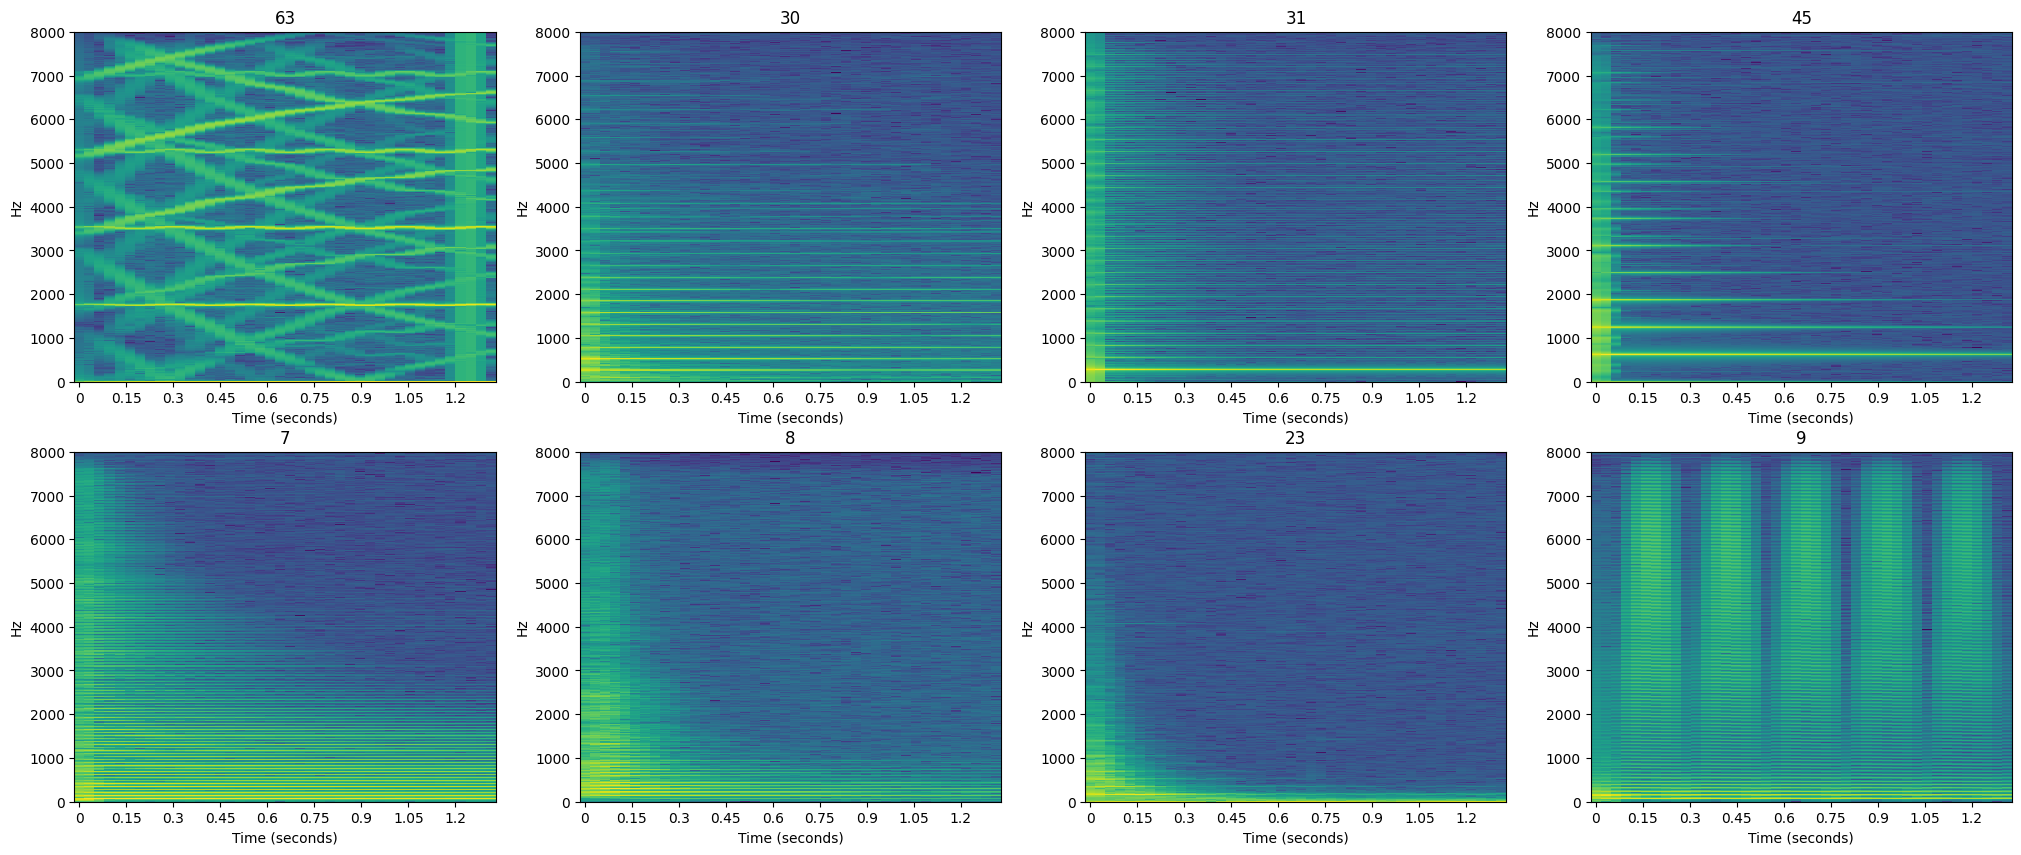

In [ ]:
drawSpec(validationData, validationLabel)

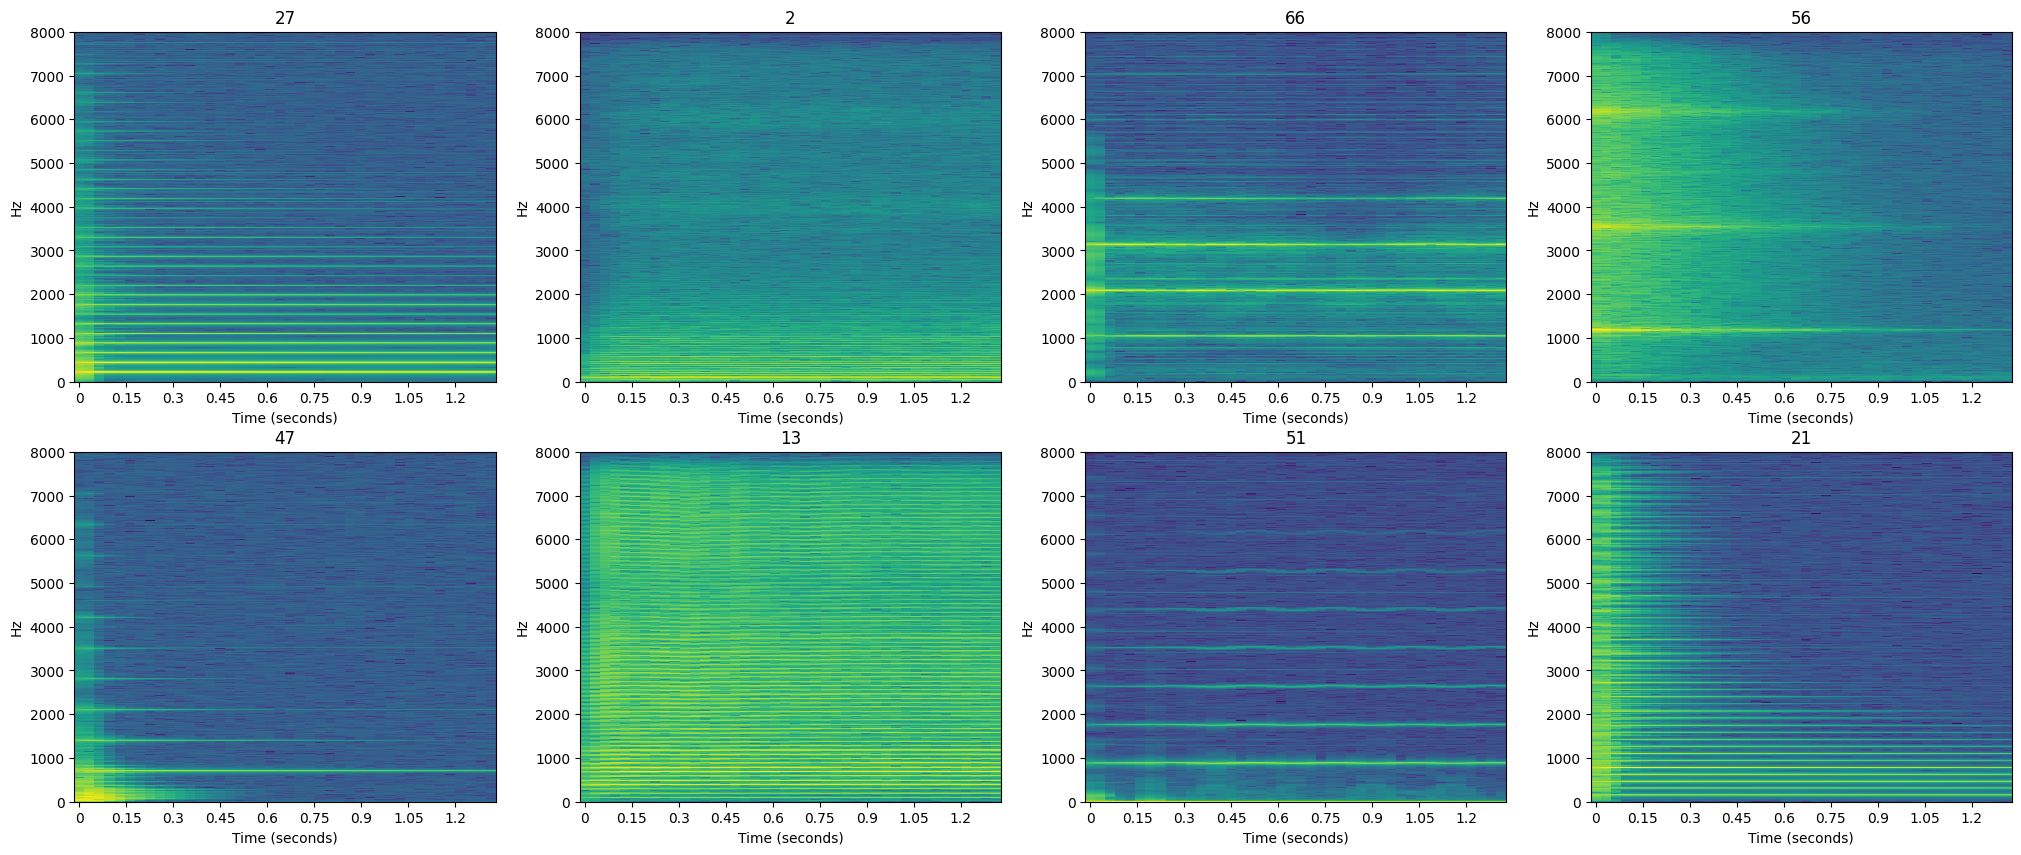

In [ ]:
drawSpec(testData, testLabel)

In [ ]:
from google.colab import drive
import numpy as np
drive.mount('/content/gdrive')

testData=np.load('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/NSynth/testData16_71Class.npy')
testLabel=np.load('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/NSynth/testLabel16_71Class.npy')
validationData=np.load('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/NSynth/validationData16_71Class.npy')
validationLabel=np.load('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/NSynth/validationLabel16_71Class.npy')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf

class CustomAttentionLayer(tf.keras.layers.Layer):
    def __init__(self,  activation=None):
        super(CustomAttentionLayer, self).__init__()
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):

        self.input_dim = input_shape[-1]
        self.w = self.add_weight(
            shape=(self.input_dim,1),
            initializer="random_normal",
            trainable=True,
        )
        

    def call(self, inputs):        
        
        alphaVector = tf.reshape(self.activation(self.w), shape=[32,])
        # attentionVector = tf.keras.layers.Softmax(axis=0)(alphaVector)
        
        #output = inputs*attentionVector
        
        return alphaVector

input_tensor = tf.keras.layers.Input(shape=(7,6,32), batch_size=None)
layer = CustomAttentionLayer(activation='tanh')(input_tensor)
layer.shape

TensorShape([32])

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout, Resizing, BatchNormalization, Activation, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

def buildModel(inputAudio):

  layer1 = Conv2D(32, 3, activation='relu')(inputAudio)  
  layerb = BatchNormalization()(layer1)
  layer2 = MaxPooling2D()(layerb)
  layerd = Dropout(0.25)(layer2)
  layer3 = Conv2D(32, 3, activation='relu')(layerd)  
  layer4 = MaxPooling2D()(layer3)
  layerd1 = Dropout(0.25)(layer4)
  layer5 = Conv2D(32, 3, activation='relu')(layerd1)
  layer6 = MaxPooling2D()(layer5)  
  layerd2 = Dropout(0.25)(layer6)
  layer7 = Conv2D(32, 3, activation='relu')(layerd2)

  attention2D = Conv2D(32, 3, activation=None, padding = 'same')(layer7)
  attentionMap = tf.keras.layers.Softmax()(attention2D)
  multiplyLayer = tf.keras.layers.Multiply()([layer7, attentionMap])

  # alphaLayer = CustomAttentionLayer(activation='tanh')(layer7)
  # attentionLayer = tf.keras.layers.Softmax()(alphaLayer)
  # multiplyLayer = layer7*attentionLayer

  #layer8 = MaxPooling2D()(layer7)  
  layer9 = Dropout(0.25)(multiplyLayer)   
  layer10 = Flatten()(layer9)
  layer11 = Dense(512, activation='relu')(layer10)
  layerd3 = Dropout(0.25)(layer11)  
  layer13 = Dense(128, activation='relu')(layerd3)   
  layerd4 = Dropout(0.25)(layer13)  
  layer14 = Dense(71, activation='softmax')(layerd4) 

  return layer14
numOfRow=1025
numOfColumn=42
inputSignal = Input(shape=(numOfRow, numOfColumn, 1))
model=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1025, 42, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 1023, 40, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 1023, 40, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath='/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_NSynth_71Class_attention_Conv2D.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',verbose=2, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
    
batch_size=32
epochs=30

hist=model.fit( validationData,
                validationLabel,
                epochs=epochs,
                shuffle=True,
                batch_size=batch_size,
                verbose=2,
                validation_split=0.15,
                callbacks=callbacks_list)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.71748, saving model to /content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_NSynth_71Class_attention_Conv2D.h5
270/270 - 37s - loss: 1.9327 - accuracy: 0.5343 - val_loss: 2.1055 - val_accuracy: 0.7175 - 37s/epoch - 137ms/step
Epoch 2/30

Epoch 2: val_accuracy improved from 0.71748 to 0.91327, saving model to /content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_NSynth_71Class_attention_Conv2D.h5
270/270 - 19s - loss: 0.6411 - accuracy: 0.8352 - val_loss: 0.4052 - val_accuracy: 0.9133 - 19s/epoch - 71ms/step
Epoch 3/30

Epoch 3: val_accuracy improved from 0.91327 to 0.93693, saving model to /content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_NSynth_71Class_attention_Conv2D.h5
270/270 - 19s - loss: 0.3935 - accuracy: 0.8960 - val_loss: 0.2704 - val_accuracy: 0.9369 - 19s/epoch - 70ms/step
Epoch 4/30

Epoch 4: val_accuracy improved from 0.93693 to 0.95466, saving model to /content/

In [ ]:
filepath='/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_NSynth_71Class_attention_Conv2D.h5'
predModel=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
predModel.load_weights(filepath)
predModel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

test_dataset = tf.data.Dataset.from_tensor_slices((testData, testLabel))
test_dataset = test_dataset.batch(32)
result = predModel.evaluate(test_dataset)

103/103 [==============================] - 2s 14ms/step - loss: 0.0703 - accuracy: 0.9827


In [ ]:
import numpy as np
from google.colab import drive
#drive.mount('/content/gdrive')

testData=np.load('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/trainData16_71Class.npy')
testLabel=np.load('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/trainLabel16_71Class.npy')

filepath='/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_NSynth_71Class_attention_Conv2D.h5'
predModel=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
predModel.load_weights(filepath)
predModel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

test_dataset = tf.data.Dataset.from_tensor_slices((testData, testLabel))
test_dataset = test_dataset.batch(32)
result = predModel.evaluate(test_dataset)

90/90 [==============================] - 2s 13ms/step - loss: 0.0100 - accuracy: 0.9975


In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')

testData=np.load('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/NSynth/testData16_71Class.npy')
testLabel=np.load('/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Dataset/NSynth/testLabel16_71Class.npy')

filepath='/content/gdrive/MyDrive/TinySOL Musical Note Recognation/Models/Model_TinySOL_71Class_attention_Conv2D.h5'
predModel=Model(inputs=inputSignal, outputs=buildModel(inputSignal))
predModel.load_weights(filepath)
predModel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

test_dataset = tf.data.Dataset.from_tensor_slices((testData, testLabel))
test_dataset = test_dataset.batch(32)
result = predModel.evaluate(test_dataset)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
103/103 [==============================] - 2s 11ms/step - loss: 1.7288 - accuracy: 0.8384
